# Van der Pauw Method for Determining Sheet Resistance

Van der Pauw method is a well established technique for resistivity and hall measurements. It can provide a great deal of information regarding the resistivity, carrier density, major carrier mobility, and sheet resistance of an arbitrarily shaped conducting sample. To use Van der Pauw, however, there are some prerequisites that one should consider, some of which are; the sample must be uniform and negligibly thin, should be free of holes and non-conducting holes. The contact diameter should be negligible as compared to the available sample area. 

Since the goal is to measure very small resistance that leads to the very small resistance, typically in the order of a couple of ohms, the current is fed into the sample using one terminal and taken out from another terminal. Then the voltage is measured from the remaining two terminals. Hence, in a typical Van der Pauw method, four connections are made viz. 1, 2, 3, and 4. Then by sending current through 1 and 2, voltage is measured using terminals 3 and 4. This gives a characteristic resistance ($R_A$ let’s say). In the next step, the current is fed through terminals 1 and 3, then voltage is measured using 2 and 4 resulting in another characteristic resistance $R_B$. These two resistances (i.e., $R_A$ and $R_B$) can used to determine the sheet resistance ($R_s$) by solving the equation below; $$\exp (\frac{-\pi R_A}{R_s}) + \exp (\frac{-\pi R_B}{R_s}) = 1  \tag{1}$$

Once the sheet resistance is determined, the bulk resistivity can be obtained as; $$ \rho = R_sd \tag{2}$$ where d is the thickness of the sample.


Equation (1) can be solved by fixed point method. Algorithm for obtaining $R_s$ can be found at NIST website [[Link]](https://www.nist.gov/pml/nanoscale-device-characterization-division/popular-links/hall-effect/hall-effect-measurements-2).

Below, we try to implement this algorithm using python.

The algorithm requires three functions;
$$ initial\ value\ of\ z_i,\ or\ z_0 = \frac{2\ln(2)}{\pi (R_A+R_B)}\tag{3}$$
$$ y_i = \frac{1}{\exp(\pi z_{i-1}R_A)} + \frac{1}{\exp(\pi z_{i-1}R_B)} \tag{4}$$


$$ z_i = z_{i-1} - \frac{[\frac{1-y_i}{\pi}]}{\frac{R_A}{\exp(\pi z_{i-1}R_A)}+\frac{R_B}{\exp(\pi z_{i-1}R_B)}}\tag{5}$$

Find $z_i$ until $(z_i - z_{i-1})/z_i$ is greater than $\delta$ (a number defined as error limit). Then $R_s = 1/z_i$




In [28]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
# function for equation (3)
pi = round(np.pi,5)
def z_0(RA, RB):
    return 2.0*math.log(2.0)/(pi*(RA+RB))


# function for equation (4)
def y_i(z_prev, RA, RB):
    return (1/math.exp(pi*z_prev*RA)) + (1/math.exp(pi*z_prev*RB))


# function for equation (5)
def z_i(z_prev, RA, RB):
    y_i = y_i(z_prev, RA, RB)
    z_i = z_prev - ((1-y_i)/pi)*((RA/(math.exp(pi*z_prev*RA))) + (RB/(math.exp(pi*z_prev*RB))))
    
    
# find z_i by iteration until the error limit is achieved. 
def FindRs(RA, RB):
    error_lim = 1e-8
    i = 0
    z_prev = z_0(RA, RB)
    diff = 0    # diff = (z_i - z_prev)/z_i
    while diff >= error_lim:
        y_i = y_i(z_prev, RA, RB) 
        z_i = z_i(z_prev, RA, RB)
        diff = (z_i - z_prev)/z_i
        z_prev = z_i
    return 1/z_prev       


Now, one can determine the temperature dependent resisivity from the raw measurement file (in this case we use output file of Quantum Design PPMS with resistivity option). The raw file contains both $R_A$ and $R_B$ at each temperature, but they are recorded one row apart. Hence, first we need to modify the raw file so that at each temperature we have both $R_A$ and $R_B$ in a single-row.

Below, we read the file and drop all the unnecessary columns, rename the characteristics resistances and RA and RB.

In [30]:
import os
import pandas as pd
file_path = '\\Users\shambhu\Box Sync\Heusler project\Heusler project (skc@ua.edu)\Fe-Co-Ti-Ge system\FeCo1.5Ti0.5Ge\950C3D\RT'
file_name = 'FeCo1.5Ti0.5ge950c3d_ch1_ch2_RT.dat'
file = os.path.join(file_path, file_name)
df = pd.read_csv(file, skiprows=30, delimiter = ',')
columns_to_keep=['Temperature (K)','Bridge 1 Resistance (Ohms)','Bridge 2 Resistance (Ohms)']
df = df[columns_to_keep]
df.rename(columns={'Temperature (K)':'Temp','Bridge 1 Resistance (Ohms)':'RA','Bridge 2 Resistance (Ohms)':'RB'},inplace=True)

df.head(10)

,Temp,RA,RB
0,400.141177,0.000392,NaN
1,400.143654,NaN,0.000175
2,398.116829,0.000396,NaN
3,398.102892,NaN,0.000171
4,396.077686,0.000392,NaN
5,396.064014,NaN,0.000170
6,394.070232,0.000389,NaN
7,394.055774,NaN,0.000173
8,392.063474,0.000385,NaN
9,392.050906,NaN,0.000173


As we can see RA and RB are seperated by a row. The temperature difference corresponding to the RA and RB is very small, so it should be fine to take only one temperature and assign both the RA and RB to it. 

In [31]:
df.drop(df.index[len(df)-1])
ch1_df = df.iloc[::2]     # select only even lines from data
ch2_df = df.iloc[1::2]    # select only odd lines from data
RA = ch1_df.RA.values.tolist()
RB = ch2_df.RB.values.tolist()   # create list of R1 arrays
ch1_df = ch1_df.reset_index()
ch2_df = ch2_df.reset_index()
ch2_df = ch2_df['RB']
ch1_df['RB'] =ch2_df 
ch1_df.head()

,index,Temp,RA,RB
0,0,400.141177,0.000392,0.000175
1,2,398.116829,0.000396,0.000171
2,4,396.077686,0.000392,0.000170
3,6,394.070232,0.000389,0.000173
4,8,392.063474,0.000385,0.000173


Calculating $R_s$ and adding to the dataframe.

In [33]:
Rs = []
for k in range(len(RA)):
    Rs_k = FindRs(RA[k],RB[k])
    Rs.append(Rs_k)
    
ch1_df['Rs'] = pd.Series(np.array(Rs))
ch1_df.head()   

,index,Temp,RA,RB,Rs
0,0,400.141177,0.000392,0.000175,0.001283
1,2,398.116829,0.000396,0.000171,0.001286
2,4,396.077686,0.000392,0.000170,0.001273
3,6,394.070232,0.000389,0.000173,0.001273
4,8,392.063474,0.000385,0.000173,0.001265


### Plotting and visualization

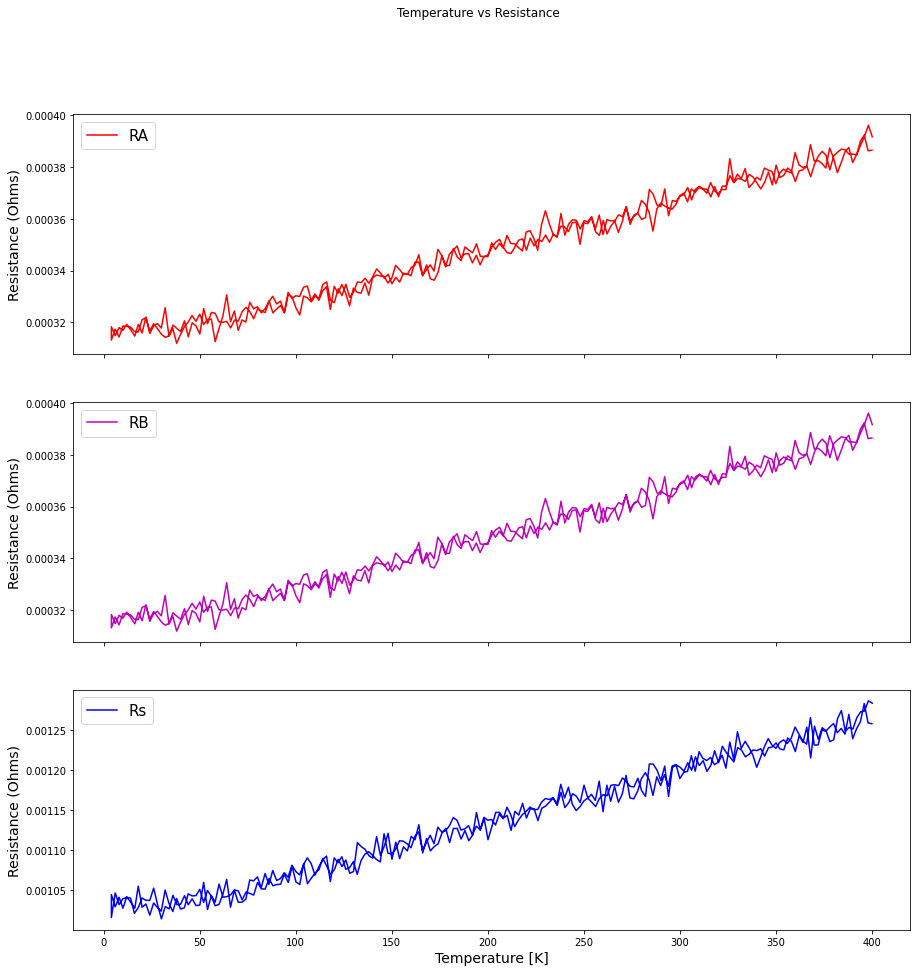

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(15,15))
fig.suptitle('Temperature vs Resistance')
ax1.plot(ch1_df.Temp, ch1_df.RA, color='r', label='RA')
ax2.plot(ch1_df.Temp, ch1_df.RA, color='m', label='RB')
ax3.plot(ch1_df.Temp, ch1_df.Rs, color='b', label='Rs')
plt.xlabel('Temperature [K]', fontsize=14)
ax1.set_ylabel(r'Resistance (Ohms)', fontsize=14)
ax2.set_ylabel(r'Resistance (Ohms)', fontsize=14)
ax3.set_ylabel(r'Resistance (Ohms)', fontsize=14)
ax1.legend(fontsize=15)
ax2.legend(fontsize=15)
ax3.legend(fontsize=15)

### Data saving

In [63]:
outfile = os.path.join(file_path, file_name.strip('.dat'))
ch1_df.to_csv(outfile+'Rs_added', sep='\t')

One can open the file with excel and use it for their purpose